# Volumetric quantification

Note: this notebook skips 'ANTs Registration' [1] step (can be found in [full version notebook](https://colab.research.google.com/drive/1mnlBcRBxpLb2QbcVqQsU5p50fRaM5Ifq?usp=sharing)).

In this notebook, we start at transformed MRI scans in SIGMA space [2] via ANTs (antsRegistrationSyNQuick.sh).
The brain structure volumes are computed using thoes files as well as SIGMA atlas.

Reference:

[1] Avants, Brian B., Nick Tustison, and Gang Song. "Advanced normalization tools (ANTS)." Insight j 2.365 (2009): 1-35.

[2] Barrière, D. A., et al. "The SIGMA rat brain templates and atlases for multimodal MRI data analysis and visualization." Nature communications 10.1 (2019): 1-13.

---
<font size=5>Table of Contents</font>

* [Longitudinal Study Overview](#0)
  * [1.1 Download code and MRI data.](#1.1)
  * [1.2 Declare key function and path](#1.2)
  * [1.3 Visualize the quality of registration using different pipeline before computing volumes](#1.3)

* [2.0 Compute volume in different piplelines](#0)
  * [2.1 Compute brain structure volume using BEN in pipeline](#2.1)
  * [2.2 Compute brain structure volume using AFNI in pipeline](#2.2)
  * [2.3 Compute brain structure volume without brain extraction in pipeline.](#2.3)

* [3.0 Plot longitudinal data (hippocampus and thalamus)](#3.0)
  * [3.1 Using BEN as preprocessing pipeline](#3.1)
  * [3.2 Using AFNI as preprocessing pipeline](#3.2)
  * [3.3 W/o BEN as preprocessing pipeline](#3.3)
* [4.0 Conclusion](#4.0)

---



<a name="0"></a>
#  Longitudinal Study Overview
Adolescent rats (3, 6, 9, and 12 weeks old)

**<font color='#FF000'> Conclusion: </font>**

Using ***BEN*** as the preprocessing pipeline before registration can observe the development of brain structure volumes, while others fail.


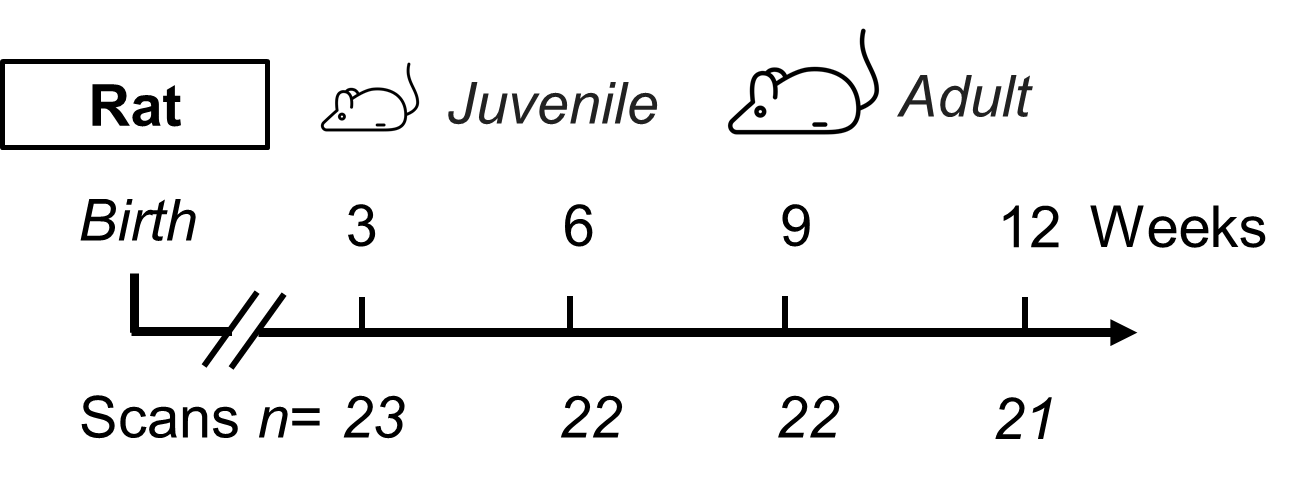

<a id="0">

## 1.1 Download code and MRI data. <a name="1.1"></a>

In [ ]:
!git clone https://github.com/yu02019/BEN.git

Cloning into 'BEN'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 146 (delta 0), reused 0 (delta 0), pack-reused 143
Receiving objects: 100% (146/146), 6.38 MiB | 13.35 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [ ]:
cd BEN

/content/BEN


In [ ]:
!gdown --id 1v4ZFCXJkLcO3HnLU1m4stim1oHlupyv6
!unzip data_for_ants.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1v4ZFCXJkLcO3HnLU1m4stim1oHlupyv6
To: /content/BEN/data_for_ants.zip
100% 25.3M/25.3M [00:00<00:00, 107MB/s] 
Archive:  data_for_ants.zip
   creating: Native-label-afni-brain/
  inflating: Native-label-afni-brain/21d_cas_27_T2.nii.gz  
  inflating: Native-label-afni-brain/21d_cas_38_T2.nii.gz  
  inflating: Native-label-afni-brain/21d_cas_39_T2.nii.gz  
  inflating: Native-label-afni-brain/21d_cas_40_T2.nii.gz  
  inflating: Native-label-afni-brain/21d_cas_41_T2.nii.gz  
  inflating: Native-label-afni-brain/21d_cas_42_T2.nii.gz  
  inflating: Native-label-afni-brain/21d_cas_43_T2.nii.gz  
  inflating: Native-label-afni-brain/21d_cas_44_T2.nii.gz  
  inflating: Native-label-afni-brain/21d_cas_45_T2.nii.gz  
  inflat

In [ ]:
!pip install simpleitk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 22 kB/s 


<a name="1.2"></a>
## 1.2 Declare key function and path

In [ ]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from glob import glob
from tqdm import tqdm
from collections import OrderedDict
from utils.load_data import get_itk_array, get_itk_image

import seaborn as sns
import matplotlib.pyplot as plt

Define the function to compute brain structure volume.


*   input: Folder path for MRI scans processed by pipeline.
*   output: Numerical results and saved in csv file.
*   structure_list: Brain structure label ID. Details can be found in [Sec2.1](#2.1)



In [ ]:
def compute_volume(path = glob(r'Native-label-brain/*nii.gz'), save_name=r'sigma-tha-label-brain.csv', structure_list=[]):
  results = []
  for i in tqdm(path):
      name = os.path.basename(i)
      print(name, end='\t')

      nii = get_itk_image(i)
      zoom = nii.GetSpacing()
      zoom = zoom[0]*zoom[1]*zoom[2]

      nii = nib.load(i)
      nii = nii.get_fdata()
      nii = nii.astype('int')

      volume = 0
      for class_id in structure_list:  # e.g. tha_list
          nii_one_class = np.copy(nii)
          nii_one_class[nii_one_class != class_id] = 0
          nii_one_class[nii_one_class > 0] = 1
          volume += nii_one_class.sum() * zoom

      results.append((name, volume, class_id))

  results = pd.DataFrame(results)
  results.to_csv(save_name, index=False, mode='a') 

In [ ]:
# Function for boxplot
def plot_box(filename=r'sigma-tha-afni-brain.csv', cmap=sns.color_palette("Greens")):
  colors = cmap

  data = pd.read_csv(filename)
  data.columns=['Name', 'Volume', 'ID',]
  time_df = pd.DataFrame(['3 week']*23 + ['6 week']*22 + ['9 week']*22 + ['12 week']*21)
  data['Time'] = time_df  # add time column

  time_list = np.unique(data['Time'])
  print(time_list)  
  class_id_list = np.unique(data['ID'])
  print(class_id_list)

  data = data.sort_values(by='Time', ascending=True)  

  for class_id in class_id_list:  

    if 'tha' in filename:
      structure_name = 'thalamus' 
    else:
      structure_name = 'hippocampus'
    ''' box plot '''
    sns.boxplot(x=data['Time'], y=data['Volume'],
                data=data,
                palette=colors,
                order=['3 week', '6 week', '9 week', '12 week'],
                )
    ''' stripplot '''
    sns.stripplot(x=data['Time'], y=data['Volume'],
                  data=data,
                  dodge=True, 
                  jitter=0.25,
                  alpha=0.6,
                  size=5,
                  palette=colors,
                  edgecolor='black', 
                  linewidth=1, 
                  order=['3 week', '6 week', '9 week', '12 week'],
                  )
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.xlabel(xlabel='Age', fontsize=18)
    plt.ylabel(ylabel='Volume of {} (mm3)'.format(structure_name), fontsize=18)
    plt.show()
    # plt.cla()

## 1.3 Visualize the quality of registration using different pipeline before computing volumes <a name="1.3"></a>




For each scan, antsRegistration will generate output files look like this:



| Filename                       | Use                                     |
|--------------------------------|-----------------------------------------|
| {name_id}_0GenericAffine.mat   | **<font color='#FF000'> Linear transform matrix </font>**                |
| {name_id}_1InverseWarp.nii.gz  | **<font color='#FF000'> Inverse nonlinear trans mat </font>**        |
| {name_id}_1Warp.nii.gz         | Nonlinear trans mat                     |
| {name_id}_InverseWarped.nii.gz | **Inverse** warped/transformed MRI scan |
| {name_id}_Warped.nii.gz        | Warped/transformed MRI scan             |


As registration takes long time for all data and different method pipelines (>48 hours), we provide inverse transformation matrix here (**<font color='#FF000'>red</font>** in Table), in order to transform atlas labels to native space.

These trans mat were acquired using command in full version [notebook](https://colab.research.google.com/drive/1mnlBcRBxpLb2QbcVqQsU5p50fRaM5Ifq?usp=sharing#3.0) Section 3.0. With these mat, we can also tranform label/mask/annotation/etc between two space bidirectionally. In other word, this is how to do atlas-based brain structure segmentation.



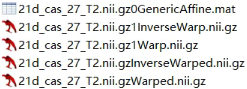

---

<a name='2.0'></a>
# 2.0 Computing brain volume using different pipelines.

<a name="2.1"></a>
## 2.1 Computing brain structure volume using ***BEN*** in pipeline

Brain structure label list is from SIGMA atlas [1].
Next we will compute the volume with these corresponding label ID.

Trans matrices acquired using registration: BEN processed MRI -> Atlas)



Reference:

[1] Barrière, D. A., et al. "The SIGMA rat brain templates and atlases for multimodal MRI data analysis and visualization." Nature communications 10.1 (2019): 1-13.

In [ ]:
''' This cell will take about 5 mins to compute hippocampus and thalamus volumes for each MRI scan using BEN '''
# Enumerate files in BEN pipeline folder
path = glob(r'Native-label-brain/*nii.gz')  # tranformed SIGMA atlas labels. (from atlas space to each native space)
path.sort(reverse=False)

# Hippocampus label ID list
hipp_list = [71, 72, 81, 82, 91, 92, 101, 102, 151, 152, 371, 372, 471, 472, 741, 742]
# Thalamus label ID list
tha_list = [61, 62, 861, 862, 951, 952, 1021, 1022, 1111, 1112, 1131, 1132, 1151, 1152, 931, 932, 231, 232]

# Compute hippocampus volume
compute_volume(path=path, save_name=r'sigma-tha-label-BEN-brain.csv', structure_list=tha_list)
# Compute thalamus volume
compute_volume(path=path, save_name=r'sigma-hipp-label-BEN-brain.csv', structure_list=hipp_list)

  0%|          | 0/88 [00:00<?, ?it/s]

21d_cas_27_T2.nii.gz	

  1%|          | 1/88 [00:01<02:53,  2.00s/it]

21d_cas_38_T2.nii.gz	

  2%|▏         | 2/88 [00:04<02:54,  2.02s/it]

21d_cas_39_T2.nii.gz	

  3%|▎         | 3/88 [00:06<03:02,  2.15s/it]

21d_cas_40_T2.nii.gz	

  5%|▍         | 4/88 [00:09<03:22,  2.41s/it]

21d_cas_41_T2.nii.gz	

  6%|▌         | 5/88 [00:11<03:19,  2.40s/it]

21d_cas_42_T2.nii.gz	

  7%|▋         | 6/88 [00:14<03:20,  2.45s/it]

21d_cas_43_T2.nii.gz	

  8%|▊         | 7/88 [00:17<03:32,  2.63s/it]

21d_cas_44_T2.nii.gz	

  9%|▉         | 8/88 [00:19<03:26,  2.58s/it]

21d_cas_45_T2.nii.gz	

 10%|█         | 9/88 [00:22<03:35,  2.73s/it]

21d_cas_46_T2.nii.gz	

 11%|█▏        | 10/88 [00:25<03:39,  2.81s/it]

21d_cas_47_T2.nii.gz	

 12%|█▎        | 11/88 [00:28<03:32,  2.75s/it]

21d_cas_48_T2.nii.gz	

 14%|█▎        | 12/88 [00:29<03:04,  2.43s/it]

21d_con_26_T2.nii.gz	

 15%|█▍        | 13/88 [00:31<02:44,  2.19s/it]

21d_con_28_T2.nii.gz	

 16%|█▌        | 14/88 [00:33<02:30,  2.04s/it]

21d_con_29_T2.nii.gz	

 17%|█▋        | 15/88 [00:34<02:20,  1.92s/it]

21d_con_30_T2.nii.gz	

 18%|█▊        | 16/88 [00:36<02:11,  1.83s/it]

21d_con_31_T2.nii.gz	

 19%|█▉        | 17/88 [00:38<02:05,  1.77s/it]

21d_con_32_T2.nii.gz	

 20%|██        | 18/88 [00:39<02:01,  1.73s/it]

21d_con_33_T2.nii.gz	

 22%|██▏       | 19/88 [00:41<01:57,  1.70s/it]

21d_con_34_T2.nii.gz	

 23%|██▎       | 20/88 [00:43<01:54,  1.68s/it]

21d_con_35_T2.nii.gz	

 24%|██▍       | 21/88 [00:44<01:51,  1.66s/it]

21d_con_36_T2.nii.gz	

 25%|██▌       | 22/88 [00:46<01:49,  1.66s/it]

21d_con_37_T2.nii.gz	

 26%|██▌       | 23/88 [00:47<01:47,  1.65s/it]

42d_cas_27_T2.nii.gz	

 27%|██▋       | 24/88 [00:49<01:45,  1.65s/it]

42d_cas_38_T2.nii.gz	

 28%|██▊       | 25/88 [00:51<01:43,  1.64s/it]

42d_cas_39_T2.nii.gz	

 30%|██▉       | 26/88 [00:52<01:41,  1.64s/it]

42d_cas_40_T2.nii.gz	

 31%|███       | 27/88 [00:54<01:39,  1.63s/it]

42d_cas_41_T2.nii.gz	

 32%|███▏      | 28/88 [00:56<01:37,  1.63s/it]

42d_cas_42_T2.nii.gz	

 33%|███▎      | 29/88 [00:57<01:36,  1.63s/it]

42d_cas_43_T2.nii.gz	

 34%|███▍      | 30/88 [00:59<01:34,  1.62s/it]

42d_cas_44_T2.nii.gz	

 35%|███▌      | 31/88 [01:00<01:32,  1.62s/it]

42d_cas_45_T2.nii.gz	

 36%|███▋      | 32/88 [01:02<01:30,  1.62s/it]

42d_cas_46_T2.nii.gz	

 38%|███▊      | 33/88 [01:04<01:29,  1.63s/it]

42d_cas_47_T2.nii.gz	

 39%|███▊      | 34/88 [01:05<01:27,  1.63s/it]

42d_con_26_T2.nii.gz	

 40%|███▉      | 35/88 [01:07<01:26,  1.64s/it]

42d_con_28_T2.nii.gz	

 41%|████      | 36/88 [01:09<01:24,  1.63s/it]

42d_con_29_T2.nii.gz	

 42%|████▏     | 37/88 [01:10<01:23,  1.63s/it]

42d_con_30_T2.nii.gz	

 43%|████▎     | 38/88 [01:12<01:21,  1.63s/it]

42d_con_31_T2.nii.gz	

 44%|████▍     | 39/88 [01:13<01:19,  1.62s/it]

42d_con_32_T2.nii.gz	

 45%|████▌     | 40/88 [01:15<01:17,  1.62s/it]

42d_con_33_T2.nii.gz	

 47%|████▋     | 41/88 [01:17<01:17,  1.64s/it]

42d_con_34_T2.nii.gz	

 48%|████▊     | 42/88 [01:18<01:14,  1.62s/it]

42d_con_35_T2.nii.gz	

 49%|████▉     | 43/88 [01:20<01:11,  1.58s/it]

42d_con_36_T2.nii.gz	

 50%|█████     | 44/88 [01:21<01:09,  1.57s/it]

42d_con_37_T2.nii.gz	

 51%|█████     | 45/88 [01:23<01:06,  1.55s/it]

63d_cas_27_T2.nii.gz	

 52%|█████▏    | 46/88 [01:24<01:05,  1.56s/it]

63d_cas_38_T2.nii.gz	

 53%|█████▎    | 47/88 [01:26<01:03,  1.56s/it]

63d_cas_39_T2.nii.gz	

 55%|█████▍    | 48/88 [01:28<01:02,  1.56s/it]

63d_cas_40_T2.nii.gz	

 56%|█████▌    | 49/88 [01:29<01:00,  1.56s/it]

63d_cas_42_T2.nii.gz	

 57%|█████▋    | 50/88 [01:31<00:58,  1.55s/it]

63d_cas_43_T2.nii.gz	

 58%|█████▊    | 51/88 [01:32<00:57,  1.55s/it]

63d_cas_44_T2.nii.gz	

 59%|█████▉    | 52/88 [01:34<00:55,  1.55s/it]

63d_cas_45_T2.nii.gz	

 60%|██████    | 53/88 [01:35<00:54,  1.55s/it]

63d_cas_46_T2.nii.gz	

 61%|██████▏   | 54/88 [01:37<00:52,  1.55s/it]

63d_cas_47_T2.nii.gz	

 62%|██████▎   | 55/88 [01:38<00:51,  1.56s/it]

63d_cas_48_T2.nii.gz	

 64%|██████▎   | 56/88 [01:40<00:49,  1.56s/it]

63d_con_26_T2.nii.gz	

 65%|██████▍   | 57/88 [01:42<00:48,  1.57s/it]

63d_con_28_T2.nii.gz	

 66%|██████▌   | 58/88 [01:43<00:46,  1.56s/it]

63d_con_29_T2.nii.gz	

 67%|██████▋   | 59/88 [01:45<00:45,  1.56s/it]

63d_con_30_T2.nii.gz	

 68%|██████▊   | 60/88 [01:46<00:43,  1.57s/it]

63d_con_31_T2.nii.gz	

 69%|██████▉   | 61/88 [01:48<00:42,  1.57s/it]

63d_con_32_T2.nii.gz	

 70%|███████   | 62/88 [01:49<00:40,  1.56s/it]

63d_con_33_T2.nii.gz	

 72%|███████▏  | 63/88 [01:51<00:38,  1.56s/it]

63d_con_34_T2.nii.gz	

 73%|███████▎  | 64/88 [01:52<00:37,  1.55s/it]

63d_con_35_T2.nii.gz	

 74%|███████▍  | 65/88 [01:54<00:35,  1.55s/it]

63d_con_36_T2.nii.gz	

 75%|███████▌  | 66/88 [01:56<00:34,  1.56s/it]

63d_con_37_T2.nii.gz	

 76%|███████▌  | 67/88 [01:57<00:32,  1.56s/it]

90d_cas_27_T2.nii.gz	

 77%|███████▋  | 68/88 [01:59<00:31,  1.56s/it]

90d_cas_38_T2.nii.gz	

 78%|███████▊  | 69/88 [02:00<00:29,  1.56s/it]

90d_cas_39_T2.nii.gz	

 80%|███████▉  | 70/88 [02:02<00:28,  1.56s/it]

90d_cas_40_T2.nii.gz	

 81%|████████  | 71/88 [02:03<00:26,  1.55s/it]

90d_cas_42_T2.nii.gz	

 82%|████████▏ | 72/88 [02:05<00:24,  1.56s/it]

90d_cas_44_T2.nii.gz	

 83%|████████▎ | 73/88 [02:07<00:23,  1.55s/it]

90d_cas_45_T2.nii.gz	

 84%|████████▍ | 74/88 [02:08<00:21,  1.55s/it]

90d_cas_46_T2.nii.gz	

 85%|████████▌ | 75/88 [02:10<00:20,  1.55s/it]

90d_cas_47_T2.nii.gz	

 86%|████████▋ | 76/88 [02:11<00:18,  1.55s/it]

90d_cas_48_T2.nii.gz	

 88%|████████▊ | 77/88 [02:13<00:17,  1.55s/it]

90d_con_26_T2.nii.gz	

 89%|████████▊ | 78/88 [02:15<00:18,  1.83s/it]

90d_con_28_T2.nii.gz	

 90%|████████▉ | 79/88 [02:17<00:16,  1.87s/it]

90d_con_29_T2.nii.gz	

 91%|█████████ | 80/88 [02:19<00:14,  1.78s/it]

90d_con_30_T2.nii.gz	

 92%|█████████▏| 81/88 [02:20<00:11,  1.71s/it]

90d_con_31_T2.nii.gz	

 93%|█████████▎| 82/88 [02:22<00:09,  1.65s/it]

90d_con_32_T2.nii.gz	

 94%|█████████▍| 83/88 [02:23<00:08,  1.62s/it]

90d_con_33_T2.nii.gz	

 95%|█████████▌| 84/88 [02:25<00:06,  1.60s/it]

90d_con_34_T2.nii.gz	

 97%|█████████▋| 85/88 [02:26<00:04,  1.59s/it]

90d_con_35_T2.nii.gz	

 98%|█████████▊| 86/88 [02:28<00:03,  1.58s/it]

90d_con_36_T2.nii.gz	

 99%|█████████▉| 87/88 [02:30<00:01,  1.62s/it]

90d_con_37_T2.nii.gz	

  0%|          | 0/88 [00:00<?, ?it/s]

21d_cas_27_T2.nii.gz	

  1%|          | 1/88 [00:01<02:09,  1.49s/it]

21d_cas_38_T2.nii.gz	

  2%|▏         | 2/88 [00:02<02:07,  1.48s/it]

21d_cas_39_T2.nii.gz	

  3%|▎         | 3/88 [00:04<02:06,  1.49s/it]

21d_cas_40_T2.nii.gz	

  5%|▍         | 4/88 [00:05<02:04,  1.48s/it]

21d_cas_41_T2.nii.gz	

  6%|▌         | 5/88 [00:07<02:02,  1.47s/it]

21d_cas_42_T2.nii.gz	

  7%|▋         | 6/88 [00:08<02:00,  1.47s/it]

21d_cas_43_T2.nii.gz	

  8%|▊         | 7/88 [00:10<01:58,  1.46s/it]

21d_cas_44_T2.nii.gz	

  9%|▉         | 8/88 [00:11<01:56,  1.46s/it]

21d_cas_45_T2.nii.gz	

 10%|█         | 9/88 [00:13<01:54,  1.45s/it]

21d_cas_46_T2.nii.gz	

 11%|█▏        | 10/88 [00:14<01:53,  1.46s/it]

21d_cas_47_T2.nii.gz	

 12%|█▎        | 11/88 [00:16<01:52,  1.46s/it]

21d_cas_48_T2.nii.gz	

 14%|█▎        | 12/88 [00:17<01:50,  1.45s/it]

21d_con_26_T2.nii.gz	

 15%|█▍        | 13/88 [00:18<01:48,  1.45s/it]

21d_con_28_T2.nii.gz	

 16%|█▌        | 14/88 [00:20<01:47,  1.45s/it]

21d_con_29_T2.nii.gz	

 17%|█▋        | 15/88 [00:21<01:45,  1.45s/it]

21d_con_30_T2.nii.gz	

 18%|█▊        | 16/88 [00:23<01:44,  1.45s/it]

21d_con_31_T2.nii.gz	

 19%|█▉        | 17/88 [00:24<01:43,  1.45s/it]

21d_con_32_T2.nii.gz	

 20%|██        | 18/88 [00:26<01:41,  1.45s/it]

21d_con_33_T2.nii.gz	

 22%|██▏       | 19/88 [00:27<01:39,  1.45s/it]

21d_con_34_T2.nii.gz	

 23%|██▎       | 20/88 [00:29<01:38,  1.45s/it]

21d_con_35_T2.nii.gz	

 24%|██▍       | 21/88 [00:30<01:37,  1.45s/it]

21d_con_36_T2.nii.gz	

 25%|██▌       | 22/88 [00:32<01:35,  1.45s/it]

21d_con_37_T2.nii.gz	

 26%|██▌       | 23/88 [00:33<01:34,  1.45s/it]

42d_cas_27_T2.nii.gz	

 27%|██▋       | 24/88 [00:34<01:33,  1.46s/it]

42d_cas_38_T2.nii.gz	

 28%|██▊       | 25/88 [00:36<01:31,  1.45s/it]

42d_cas_39_T2.nii.gz	

 30%|██▉       | 26/88 [00:37<01:29,  1.45s/it]

42d_cas_40_T2.nii.gz	

 31%|███       | 27/88 [00:39<01:28,  1.46s/it]

42d_cas_41_T2.nii.gz	

 32%|███▏      | 28/88 [00:40<01:27,  1.45s/it]

42d_cas_42_T2.nii.gz	

 33%|███▎      | 29/88 [00:42<01:25,  1.45s/it]

42d_cas_43_T2.nii.gz	

 34%|███▍      | 30/88 [00:43<01:24,  1.45s/it]

42d_cas_44_T2.nii.gz	

 35%|███▌      | 31/88 [00:45<01:23,  1.46s/it]

42d_cas_45_T2.nii.gz	

 36%|███▋      | 32/88 [00:46<01:21,  1.46s/it]

42d_cas_46_T2.nii.gz	

 38%|███▊      | 33/88 [00:48<01:20,  1.46s/it]

42d_cas_47_T2.nii.gz	

 39%|███▊      | 34/88 [00:49<01:18,  1.46s/it]

42d_con_26_T2.nii.gz	

 40%|███▉      | 35/88 [00:50<01:16,  1.45s/it]

42d_con_28_T2.nii.gz	

 41%|████      | 36/88 [00:52<01:15,  1.45s/it]

42d_con_29_T2.nii.gz	

 42%|████▏     | 37/88 [00:53<01:14,  1.45s/it]

42d_con_30_T2.nii.gz	

 43%|████▎     | 38/88 [00:55<01:12,  1.46s/it]

42d_con_31_T2.nii.gz	

 44%|████▍     | 39/88 [00:56<01:11,  1.45s/it]

42d_con_32_T2.nii.gz	

 45%|████▌     | 40/88 [00:58<01:09,  1.46s/it]

42d_con_33_T2.nii.gz	

 47%|████▋     | 41/88 [00:59<01:08,  1.45s/it]

42d_con_34_T2.nii.gz	

 48%|████▊     | 42/88 [01:01<01:06,  1.45s/it]

42d_con_35_T2.nii.gz	

 49%|████▉     | 43/88 [01:02<01:05,  1.44s/it]

42d_con_36_T2.nii.gz	

 50%|█████     | 44/88 [01:03<01:03,  1.44s/it]

42d_con_37_T2.nii.gz	

 51%|█████     | 45/88 [01:05<01:02,  1.45s/it]

63d_cas_27_T2.nii.gz	

 52%|█████▏    | 46/88 [01:06<01:00,  1.44s/it]

63d_cas_38_T2.nii.gz	

 53%|█████▎    | 47/88 [01:08<00:58,  1.43s/it]

63d_cas_39_T2.nii.gz	

 55%|█████▍    | 48/88 [01:09<00:56,  1.42s/it]

63d_cas_40_T2.nii.gz	

 56%|█████▌    | 49/88 [01:11<00:55,  1.43s/it]

63d_cas_42_T2.nii.gz	

 57%|█████▋    | 50/88 [01:12<00:55,  1.46s/it]

63d_cas_43_T2.nii.gz	

 58%|█████▊    | 51/88 [01:14<00:53,  1.45s/it]

63d_cas_44_T2.nii.gz	

 59%|█████▉    | 52/88 [01:15<00:51,  1.43s/it]

63d_cas_45_T2.nii.gz	

 60%|██████    | 53/88 [01:16<00:49,  1.43s/it]

63d_cas_46_T2.nii.gz	

 61%|██████▏   | 54/88 [01:18<00:48,  1.42s/it]

63d_cas_47_T2.nii.gz	

 62%|██████▎   | 55/88 [01:19<00:46,  1.41s/it]

63d_cas_48_T2.nii.gz	

 64%|██████▎   | 56/88 [01:21<00:45,  1.41s/it]

63d_con_26_T2.nii.gz	

 65%|██████▍   | 57/88 [01:22<00:43,  1.40s/it]

63d_con_28_T2.nii.gz	

 66%|██████▌   | 58/88 [01:23<00:41,  1.39s/it]

63d_con_29_T2.nii.gz	

 67%|██████▋   | 59/88 [01:25<00:40,  1.40s/it]

63d_con_30_T2.nii.gz	

 68%|██████▊   | 60/88 [01:26<00:39,  1.40s/it]

63d_con_31_T2.nii.gz	

 69%|██████▉   | 61/88 [01:28<00:37,  1.39s/it]

63d_con_32_T2.nii.gz	

 70%|███████   | 62/88 [01:29<00:36,  1.39s/it]

63d_con_33_T2.nii.gz	

 72%|███████▏  | 63/88 [01:30<00:34,  1.39s/it]

63d_con_34_T2.nii.gz	

 73%|███████▎  | 64/88 [01:32<00:33,  1.40s/it]

63d_con_35_T2.nii.gz	

 74%|███████▍  | 65/88 [01:33<00:32,  1.39s/it]

63d_con_36_T2.nii.gz	

 75%|███████▌  | 66/88 [01:34<00:30,  1.40s/it]

63d_con_37_T2.nii.gz	

 76%|███████▌  | 67/88 [01:36<00:29,  1.40s/it]

90d_cas_27_T2.nii.gz	

 77%|███████▋  | 68/88 [01:37<00:28,  1.40s/it]

90d_cas_38_T2.nii.gz	

 78%|███████▊  | 69/88 [01:39<00:26,  1.41s/it]

90d_cas_39_T2.nii.gz	

 80%|███████▉  | 70/88 [01:40<00:25,  1.40s/it]

90d_cas_40_T2.nii.gz	

 81%|████████  | 71/88 [01:42<00:23,  1.41s/it]

90d_cas_42_T2.nii.gz	

 82%|████████▏ | 72/88 [01:43<00:22,  1.40s/it]

90d_cas_44_T2.nii.gz	

 83%|████████▎ | 73/88 [01:44<00:21,  1.41s/it]

90d_cas_45_T2.nii.gz	

 84%|████████▍ | 74/88 [01:46<00:19,  1.41s/it]

90d_cas_46_T2.nii.gz	

 85%|████████▌ | 75/88 [01:47<00:18,  1.42s/it]

90d_cas_47_T2.nii.gz	

 86%|████████▋ | 76/88 [01:49<00:17,  1.42s/it]

90d_cas_48_T2.nii.gz	

 88%|████████▊ | 77/88 [01:50<00:15,  1.40s/it]

90d_con_26_T2.nii.gz	

 89%|████████▊ | 78/88 [01:51<00:13,  1.39s/it]

90d_con_28_T2.nii.gz	

 90%|████████▉ | 79/88 [01:53<00:12,  1.40s/it]

90d_con_29_T2.nii.gz	

 91%|█████████ | 80/88 [01:54<00:11,  1.41s/it]

90d_con_30_T2.nii.gz	

 92%|█████████▏| 81/88 [01:56<00:09,  1.40s/it]

90d_con_31_T2.nii.gz	

 93%|█████████▎| 82/88 [01:57<00:08,  1.40s/it]

90d_con_32_T2.nii.gz	

 94%|█████████▍| 83/88 [01:58<00:07,  1.41s/it]

90d_con_33_T2.nii.gz	

 95%|█████████▌| 84/88 [02:00<00:05,  1.40s/it]

90d_con_34_T2.nii.gz	

 97%|█████████▋| 85/88 [02:01<00:04,  1.40s/it]

90d_con_35_T2.nii.gz	

 98%|█████████▊| 86/88 [02:03<00:02,  1.40s/it]

90d_con_36_T2.nii.gz	

 99%|█████████▉| 87/88 [02:04<00:01,  1.40s/it]

90d_con_37_T2.nii.gz	

100%|██████████| 88/88 [02:05<00:00,  1.43s/it]


<a name="2.2"></a>

## 2.2 Computing brain structure volume using ***AFNI*** in pipeline

Trans matrices acquired using registration: AFNI processed MRI -> Atlas)

In [ ]:
''' This cell will take about 5 mins to compute hippocampus and thalamus volumes for each MRI scan using AFNI '''
# Enumerate files in AFNI pipeline folder
path = glob(r'Native-label-afni-brain/*nii.gz')  # tranformed SIGMA atlas labels. (from atlas space to each native space)
path.sort(reverse=False)

compute_volume(path=path, save_name=r'sigma-tha-afni-brain.csv', structure_list=tha_list)
compute_volume(path=path, save_name=r'sigma-hipp-afni-brain.csv', structure_list=hipp_list)

  0%|          | 0/88 [00:00<?, ?it/s]

21d_cas_27_T2.nii.gz	

  1%|          | 1/88 [00:01<02:18,  1.59s/it]

21d_cas_38_T2.nii.gz	

  2%|▏         | 2/88 [00:03<02:15,  1.58s/it]

21d_cas_39_T2.nii.gz	

  3%|▎         | 3/88 [00:04<02:12,  1.56s/it]

21d_cas_40_T2.nii.gz	

  5%|▍         | 4/88 [00:06<02:10,  1.56s/it]

21d_cas_41_T2.nii.gz	

  6%|▌         | 5/88 [00:07<02:10,  1.57s/it]

21d_cas_42_T2.nii.gz	

  7%|▋         | 6/88 [00:09<02:09,  1.58s/it]

21d_cas_43_T2.nii.gz	

  8%|▊         | 7/88 [00:11<02:07,  1.58s/it]

21d_cas_44_T2.nii.gz	

  9%|▉         | 8/88 [00:12<02:05,  1.57s/it]

21d_cas_45_T2.nii.gz	

 10%|█         | 9/88 [00:14<02:03,  1.56s/it]

21d_cas_46_T2.nii.gz	

 11%|█▏        | 10/88 [00:15<02:01,  1.56s/it]

21d_cas_47_T2.nii.gz	

 12%|█▎        | 11/88 [00:17<01:59,  1.55s/it]

21d_cas_48_T2.nii.gz	

 14%|█▎        | 12/88 [00:18<01:57,  1.55s/it]

21d_con_26_T2.nii.gz	

 15%|█▍        | 13/88 [00:20<01:58,  1.58s/it]

21d_con_28_T2.nii.gz	

 16%|█▌        | 14/88 [00:22<01:58,  1.60s/it]

21d_con_29_T2.nii.gz	

 17%|█▋        | 15/88 [00:23<01:55,  1.59s/it]

21d_con_30_T2.nii.gz	

 18%|█▊        | 16/88 [00:25<01:53,  1.58s/it]

21d_con_31_T2.nii.gz	

 19%|█▉        | 17/88 [00:26<01:51,  1.57s/it]

21d_con_32_T2.nii.gz	

 20%|██        | 18/88 [00:28<01:50,  1.58s/it]

21d_con_33_T2.nii.gz	

 22%|██▏       | 19/88 [00:29<01:48,  1.58s/it]

21d_con_34_T2.nii.gz	

 23%|██▎       | 20/88 [00:31<01:47,  1.58s/it]

21d_con_35_T2.nii.gz	

 24%|██▍       | 21/88 [00:33<01:45,  1.57s/it]

21d_con_36_T2.nii.gz	

 25%|██▌       | 22/88 [00:34<01:43,  1.57s/it]

21d_con_37_T2.nii.gz	

 26%|██▌       | 23/88 [00:36<01:41,  1.56s/it]

42d_cas_27_T2.nii.gz	

 27%|██▋       | 24/88 [00:37<01:40,  1.56s/it]

42d_cas_38_T2.nii.gz	

 28%|██▊       | 25/88 [00:39<01:39,  1.57s/it]

42d_cas_39_T2.nii.gz	

 30%|██▉       | 26/88 [00:40<01:37,  1.58s/it]

42d_cas_40_T2.nii.gz	

 31%|███       | 27/88 [00:42<01:35,  1.57s/it]

42d_cas_41_T2.nii.gz	

 32%|███▏      | 28/88 [00:43<01:34,  1.57s/it]

42d_cas_42_T2.nii.gz	

 33%|███▎      | 29/88 [00:45<01:32,  1.57s/it]

42d_cas_43_T2.nii.gz	

 34%|███▍      | 30/88 [00:47<01:30,  1.56s/it]

42d_cas_44_T2.nii.gz	

 35%|███▌      | 31/88 [00:48<01:28,  1.56s/it]

42d_cas_45_T2.nii.gz	

 36%|███▋      | 32/88 [00:50<01:27,  1.57s/it]

42d_cas_46_T2.nii.gz	

 38%|███▊      | 33/88 [00:51<01:26,  1.57s/it]

42d_cas_47_T2.nii.gz	

 39%|███▊      | 34/88 [00:53<01:24,  1.56s/it]

42d_con_26_T2.nii.gz	

 40%|███▉      | 35/88 [00:54<01:22,  1.56s/it]

42d_con_28_T2.nii.gz	

 41%|████      | 36/88 [00:56<01:21,  1.56s/it]

42d_con_29_T2.nii.gz	

 42%|████▏     | 37/88 [00:58<01:19,  1.56s/it]

42d_con_30_T2.nii.gz	

 43%|████▎     | 38/88 [00:59<01:17,  1.56s/it]

42d_con_31_T2.nii.gz	

 44%|████▍     | 39/88 [01:01<01:16,  1.56s/it]

42d_con_32_T2.nii.gz	

 45%|████▌     | 40/88 [01:02<01:15,  1.57s/it]

42d_con_33_T2.nii.gz	

 47%|████▋     | 41/88 [01:04<01:13,  1.57s/it]

42d_con_34_T2.nii.gz	

 48%|████▊     | 42/88 [01:05<01:11,  1.56s/it]

42d_con_35_T2.nii.gz	

 49%|████▉     | 43/88 [01:07<01:09,  1.55s/it]

42d_con_36_T2.nii.gz	

 50%|█████     | 44/88 [01:08<01:08,  1.56s/it]

42d_con_37_T2.nii.gz	

 51%|█████     | 45/88 [01:10<01:07,  1.57s/it]

63d_cas27_T2.nii.gz	

 52%|█████▏    | 46/88 [01:12<01:05,  1.57s/it]

63d_cas38_T2.nii.gz	

 53%|█████▎    | 47/88 [01:13<01:04,  1.57s/it]

63d_cas39_T2.nii.gz	

 55%|█████▍    | 48/88 [01:15<01:02,  1.56s/it]

63d_cas40_T2.nii.gz	

 56%|█████▌    | 49/88 [01:16<01:00,  1.56s/it]

63d_cas42_T2.nii.gz	

 57%|█████▋    | 50/88 [01:18<00:59,  1.55s/it]

63d_cas43_T2.nii.gz	

 58%|█████▊    | 51/88 [01:19<00:57,  1.56s/it]

63d_cas44_T2.nii.gz	

 59%|█████▉    | 52/88 [01:21<00:56,  1.56s/it]

63d_cas45_T2.nii.gz	

 60%|██████    | 53/88 [01:23<00:54,  1.56s/it]

63d_cas46_T2.nii.gz	

 61%|██████▏   | 54/88 [01:24<00:53,  1.56s/it]

63d_cas47_T2.nii.gz	

 62%|██████▎   | 55/88 [01:26<00:51,  1.56s/it]

63d_cas48_T2.nii.gz	

 64%|██████▎   | 56/88 [01:27<00:49,  1.55s/it]

63d_con26_T2.nii.gz	

 65%|██████▍   | 57/88 [01:29<00:48,  1.56s/it]

63d_con28_T2.nii.gz	

 66%|██████▌   | 58/88 [01:30<00:46,  1.56s/it]

63d_con29_T2.nii.gz	

 67%|██████▋   | 59/88 [01:32<00:45,  1.55s/it]

63d_con30_T2.nii.gz	

 68%|██████▊   | 60/88 [01:33<00:43,  1.57s/it]

63d_con31_T2.nii.gz	

 69%|██████▉   | 61/88 [01:35<00:43,  1.60s/it]

63d_con32_T2.nii.gz	

 70%|███████   | 62/88 [01:37<00:41,  1.59s/it]

63d_con33_T2.nii.gz	

 72%|███████▏  | 63/88 [01:38<00:39,  1.58s/it]

63d_con34_T2.nii.gz	

 73%|███████▎  | 64/88 [01:40<00:37,  1.58s/it]

63d_con35_T2.nii.gz	

 74%|███████▍  | 65/88 [01:41<00:36,  1.58s/it]

63d_con36_T2.nii.gz	

 75%|███████▌  | 66/88 [01:43<00:34,  1.56s/it]

63d_con37_T2.nii.gz	

 76%|███████▌  | 67/88 [01:44<00:32,  1.56s/it]

90d_cas27_T2.nii.gz	

 77%|███████▋  | 68/88 [01:46<00:31,  1.56s/it]

90d_cas38_T2.nii.gz	

 78%|███████▊  | 69/88 [01:48<00:29,  1.56s/it]

90d_cas39_T2.nii.gz	

 80%|███████▉  | 70/88 [01:49<00:28,  1.56s/it]

90d_cas40_T2.nii.gz	

 81%|████████  | 71/88 [01:51<00:26,  1.56s/it]

90d_cas42_T2.nii.gz	

 82%|████████▏ | 72/88 [01:52<00:25,  1.57s/it]

90d_cas44_T2.nii.gz	

 83%|████████▎ | 73/88 [01:54<00:23,  1.54s/it]

90d_cas45_T2.nii.gz	

 84%|████████▍ | 74/88 [01:55<00:21,  1.51s/it]

90d_cas46_T2.nii.gz	

 85%|████████▌ | 75/88 [01:57<00:19,  1.49s/it]

90d_cas47_T2.nii.gz	

 86%|████████▋ | 76/88 [01:58<00:17,  1.49s/it]

90d_cas48_T2.nii.gz	

 88%|████████▊ | 77/88 [02:00<00:16,  1.48s/it]

90d_con26_T2.nii.gz	

 89%|████████▊ | 78/88 [02:01<00:14,  1.47s/it]

90d_con28_T2.nii.gz	

 90%|████████▉ | 79/88 [02:03<00:13,  1.47s/it]

90d_con29_T2.nii.gz	

 91%|█████████ | 80/88 [02:04<00:11,  1.47s/it]

90d_con30_T2.nii.gz	

 92%|█████████▏| 81/88 [02:05<00:10,  1.48s/it]

90d_con31_T2.nii.gz	

 93%|█████████▎| 82/88 [02:07<00:08,  1.47s/it]

90d_con32_T2.nii.gz	

 94%|█████████▍| 83/88 [02:08<00:07,  1.48s/it]

90d_con33_T2.nii.gz	

 95%|█████████▌| 84/88 [02:10<00:05,  1.48s/it]

90d_con34_T2.nii.gz	

 97%|█████████▋| 85/88 [02:11<00:04,  1.48s/it]

90d_con35_T2.nii.gz	

 98%|█████████▊| 86/88 [02:13<00:02,  1.47s/it]

90d_con36_T2.nii.gz	

 99%|█████████▉| 87/88 [02:14<00:01,  1.47s/it]

90d_con37_T2.nii.gz	

  0%|          | 0/88 [00:00<?, ?it/s]

21d_cas_27_T2.nii.gz	

  1%|          | 1/88 [00:01<01:58,  1.36s/it]

21d_cas_38_T2.nii.gz	

  2%|▏         | 2/88 [00:02<01:57,  1.37s/it]

21d_cas_39_T2.nii.gz	

  3%|▎         | 3/88 [00:04<01:56,  1.37s/it]

21d_cas_40_T2.nii.gz	

  5%|▍         | 4/88 [00:05<01:53,  1.35s/it]

21d_cas_41_T2.nii.gz	

  6%|▌         | 5/88 [00:06<01:51,  1.35s/it]

21d_cas_42_T2.nii.gz	

  7%|▋         | 6/88 [00:08<01:49,  1.34s/it]

21d_cas_43_T2.nii.gz	

  8%|▊         | 7/88 [00:09<01:48,  1.34s/it]

21d_cas_44_T2.nii.gz	

  9%|▉         | 8/88 [00:10<01:47,  1.34s/it]

21d_cas_45_T2.nii.gz	

 10%|█         | 9/88 [00:12<01:46,  1.34s/it]

21d_cas_46_T2.nii.gz	

 11%|█▏        | 10/88 [00:13<01:44,  1.34s/it]

21d_cas_47_T2.nii.gz	

 12%|█▎        | 11/88 [00:14<01:43,  1.35s/it]

21d_cas_48_T2.nii.gz	

 14%|█▎        | 12/88 [00:16<01:42,  1.34s/it]

21d_con_26_T2.nii.gz	

 15%|█▍        | 13/88 [00:17<01:40,  1.34s/it]

21d_con_28_T2.nii.gz	

 16%|█▌        | 14/88 [00:18<01:38,  1.33s/it]

21d_con_29_T2.nii.gz	

 17%|█▋        | 15/88 [00:20<01:37,  1.33s/it]

21d_con_30_T2.nii.gz	

 18%|█▊        | 16/88 [00:21<01:35,  1.33s/it]

21d_con_31_T2.nii.gz	

 19%|█▉        | 17/88 [00:22<01:34,  1.34s/it]

21d_con_32_T2.nii.gz	

 20%|██        | 18/88 [00:24<01:34,  1.34s/it]

21d_con_33_T2.nii.gz	

 22%|██▏       | 19/88 [00:25<01:32,  1.34s/it]

21d_con_34_T2.nii.gz	

 23%|██▎       | 20/88 [00:26<01:31,  1.34s/it]

21d_con_35_T2.nii.gz	

 24%|██▍       | 21/88 [00:28<01:29,  1.34s/it]

21d_con_36_T2.nii.gz	

 25%|██▌       | 22/88 [00:29<01:27,  1.33s/it]

21d_con_37_T2.nii.gz	

 26%|██▌       | 23/88 [00:30<01:26,  1.34s/it]

42d_cas_27_T2.nii.gz	

 27%|██▋       | 24/88 [00:32<01:27,  1.37s/it]

42d_cas_38_T2.nii.gz	

 28%|██▊       | 25/88 [00:33<01:27,  1.38s/it]

42d_cas_39_T2.nii.gz	

 30%|██▉       | 26/88 [00:35<01:24,  1.37s/it]

42d_cas_40_T2.nii.gz	

 31%|███       | 27/88 [00:36<01:22,  1.36s/it]

42d_cas_41_T2.nii.gz	

 32%|███▏      | 28/88 [00:37<01:21,  1.35s/it]

42d_cas_42_T2.nii.gz	

 33%|███▎      | 29/88 [00:39<01:19,  1.35s/it]

42d_cas_43_T2.nii.gz	

 34%|███▍      | 30/88 [00:40<01:18,  1.35s/it]

42d_cas_44_T2.nii.gz	

 35%|███▌      | 31/88 [00:41<01:16,  1.34s/it]

42d_cas_45_T2.nii.gz	

 36%|███▋      | 32/88 [00:43<01:15,  1.34s/it]

42d_cas_46_T2.nii.gz	

 38%|███▊      | 33/88 [00:44<01:13,  1.34s/it]

42d_cas_47_T2.nii.gz	

 39%|███▊      | 34/88 [00:45<01:12,  1.34s/it]

42d_con_26_T2.nii.gz	

 40%|███▉      | 35/88 [00:47<01:10,  1.34s/it]

42d_con_28_T2.nii.gz	

 41%|████      | 36/88 [00:48<01:09,  1.33s/it]

42d_con_29_T2.nii.gz	

 42%|████▏     | 37/88 [00:49<01:07,  1.32s/it]

42d_con_30_T2.nii.gz	

 43%|████▎     | 38/88 [00:51<01:06,  1.33s/it]

42d_con_31_T2.nii.gz	

 44%|████▍     | 39/88 [00:52<01:05,  1.35s/it]

42d_con_32_T2.nii.gz	

 45%|████▌     | 40/88 [00:53<01:04,  1.35s/it]

42d_con_33_T2.nii.gz	

 47%|████▋     | 41/88 [00:55<01:03,  1.35s/it]

42d_con_34_T2.nii.gz	

 48%|████▊     | 42/88 [00:56<01:02,  1.36s/it]

42d_con_35_T2.nii.gz	

 49%|████▉     | 43/88 [00:57<01:00,  1.34s/it]

42d_con_36_T2.nii.gz	

 50%|█████     | 44/88 [00:59<00:58,  1.34s/it]

42d_con_37_T2.nii.gz	

 51%|█████     | 45/88 [01:00<00:57,  1.34s/it]

63d_cas27_T2.nii.gz	

 52%|█████▏    | 46/88 [01:01<00:56,  1.34s/it]

63d_cas38_T2.nii.gz	

 53%|█████▎    | 47/88 [01:03<00:54,  1.34s/it]

63d_cas39_T2.nii.gz	

 55%|█████▍    | 48/88 [01:04<00:53,  1.34s/it]

63d_cas40_T2.nii.gz	

 56%|█████▌    | 49/88 [01:05<00:51,  1.33s/it]

63d_cas42_T2.nii.gz	

 57%|█████▋    | 50/88 [01:07<00:50,  1.33s/it]

63d_cas43_T2.nii.gz	

 58%|█████▊    | 51/88 [01:08<00:49,  1.33s/it]

63d_cas44_T2.nii.gz	

 59%|█████▉    | 52/88 [01:09<00:47,  1.33s/it]

63d_cas45_T2.nii.gz	

 60%|██████    | 53/88 [01:11<00:46,  1.33s/it]

63d_cas46_T2.nii.gz	

 61%|██████▏   | 54/88 [01:12<00:45,  1.34s/it]

63d_cas47_T2.nii.gz	

 62%|██████▎   | 55/88 [01:13<00:44,  1.35s/it]

63d_cas48_T2.nii.gz	

 64%|██████▎   | 56/88 [01:15<00:43,  1.35s/it]

63d_con26_T2.nii.gz	

 65%|██████▍   | 57/88 [01:16<00:41,  1.35s/it]

63d_con28_T2.nii.gz	

 66%|██████▌   | 58/88 [01:17<00:40,  1.35s/it]

63d_con29_T2.nii.gz	

 67%|██████▋   | 59/88 [01:19<00:38,  1.34s/it]

63d_con30_T2.nii.gz	

 68%|██████▊   | 60/88 [01:20<00:37,  1.32s/it]

63d_con31_T2.nii.gz	

 69%|██████▉   | 61/88 [01:21<00:35,  1.33s/it]

63d_con32_T2.nii.gz	

 70%|███████   | 62/88 [01:23<00:35,  1.35s/it]

63d_con33_T2.nii.gz	

 72%|███████▏  | 63/88 [01:24<00:34,  1.36s/it]

63d_con34_T2.nii.gz	

 73%|███████▎  | 64/88 [01:26<00:32,  1.37s/it]

63d_con35_T2.nii.gz	

 74%|███████▍  | 65/88 [01:27<00:31,  1.36s/it]

63d_con36_T2.nii.gz	

 75%|███████▌  | 66/88 [01:28<00:29,  1.35s/it]

63d_con37_T2.nii.gz	

 76%|███████▌  | 67/88 [01:30<00:28,  1.34s/it]

90d_cas27_T2.nii.gz	

 77%|███████▋  | 68/88 [01:31<00:26,  1.34s/it]

90d_cas38_T2.nii.gz	

 78%|███████▊  | 69/88 [01:32<00:25,  1.35s/it]

90d_cas39_T2.nii.gz	

 80%|███████▉  | 70/88 [01:34<00:24,  1.35s/it]

90d_cas40_T2.nii.gz	

 81%|████████  | 71/88 [01:35<00:22,  1.34s/it]

90d_cas42_T2.nii.gz	

 82%|████████▏ | 72/88 [01:36<00:21,  1.34s/it]

90d_cas44_T2.nii.gz	

 83%|████████▎ | 73/88 [01:38<00:19,  1.33s/it]

90d_cas45_T2.nii.gz	

 84%|████████▍ | 74/88 [01:39<00:18,  1.33s/it]

90d_cas46_T2.nii.gz	

 85%|████████▌ | 75/88 [01:40<00:17,  1.32s/it]

90d_cas47_T2.nii.gz	

 86%|████████▋ | 76/88 [01:42<00:16,  1.33s/it]

90d_cas48_T2.nii.gz	

 88%|████████▊ | 77/88 [01:43<00:14,  1.34s/it]

90d_con26_T2.nii.gz	

 89%|████████▊ | 78/88 [01:44<00:13,  1.34s/it]

90d_con28_T2.nii.gz	

 90%|████████▉ | 79/88 [01:46<00:12,  1.36s/it]

90d_con29_T2.nii.gz	

 91%|█████████ | 80/88 [01:47<00:11,  1.40s/it]

90d_con30_T2.nii.gz	

 92%|█████████▏| 81/88 [01:48<00:09,  1.39s/it]

90d_con31_T2.nii.gz	

 93%|█████████▎| 82/88 [01:50<00:08,  1.37s/it]

90d_con32_T2.nii.gz	

 94%|█████████▍| 83/88 [01:51<00:06,  1.36s/it]

90d_con33_T2.nii.gz	

 95%|█████████▌| 84/88 [01:53<00:05,  1.37s/it]

90d_con34_T2.nii.gz	

 97%|█████████▋| 85/88 [01:54<00:04,  1.35s/it]

90d_con35_T2.nii.gz	

 98%|█████████▊| 86/88 [01:55<00:02,  1.35s/it]

90d_con36_T2.nii.gz	

 99%|█████████▉| 87/88 [01:56<00:01,  1.34s/it]

90d_con37_T2.nii.gz	

100%|██████████| 88/88 [01:58<00:00,  1.34s/it]


<a name="2.3"></a>

## 2.3 Computing brain structure volume ***without*** brain extraction in pipeline.

This typically happens in rat/mouse preprocessing pipeline. In this case, we use the raw SIGMA atlas which didn't perform brain extraction either.

Trans matrices acquired using registration: w/o brain extraction MRI -> Atlas with skull)

In [ ]:
''' This cell will take about 5 mins to compute hippocampus and thalamus volumes for each MRI scan without brain extraction'''
# Enumerate files in without brain extraction pipeline folder
path = glob(r'Native-label/*nii.gz') 
path.sort(reverse=False)

compute_volume(path=path, save_name=r'sigma-tha-WO-BEN-brain.csv', structure_list=tha_list)
compute_volume(path=path, save_name=r'sigma-hipp-WO-BEN-brain.csv', structure_list=hipp_list)

  0%|          | 0/88 [00:00<?, ?it/s]

21d_cas_27_T2.nii.gz	

  1%|          | 1/88 [00:01<02:05,  1.44s/it]

21d_cas_38_T2.nii.gz	

  2%|▏         | 2/88 [00:02<02:05,  1.46s/it]

21d_cas_39_T2.nii.gz	

  3%|▎         | 3/88 [00:04<02:04,  1.47s/it]

21d_cas_40_T2.nii.gz	

  5%|▍         | 4/88 [00:05<02:03,  1.47s/it]

21d_cas_41_T2.nii.gz	

  6%|▌         | 5/88 [00:07<02:01,  1.46s/it]

21d_cas_42_T2.nii.gz	

  7%|▋         | 6/88 [00:08<01:59,  1.46s/it]

21d_cas_43_T2.nii.gz	

  8%|▊         | 7/88 [00:10<01:57,  1.46s/it]

21d_cas_44_T2.nii.gz	

  9%|▉         | 8/88 [00:11<01:56,  1.46s/it]

21d_cas_45_T2.nii.gz	

 10%|█         | 9/88 [00:13<01:55,  1.47s/it]

21d_cas_46_T2.nii.gz	

 11%|█▏        | 10/88 [00:14<01:55,  1.48s/it]

21d_cas_47_T2.nii.gz	

 12%|█▎        | 11/88 [00:16<01:53,  1.48s/it]

21d_cas_48_T2.nii.gz	

 14%|█▎        | 12/88 [00:17<01:52,  1.47s/it]

21d_con_26_T2.nii.gz	

 15%|█▍        | 13/88 [00:19<01:50,  1.47s/it]

21d_con_28_T2.nii.gz	

 16%|█▌        | 14/88 [00:20<01:49,  1.48s/it]

21d_con_29_T2.nii.gz	

 17%|█▋        | 15/88 [00:22<01:47,  1.48s/it]

21d_con_30_T2.nii.gz	

 18%|█▊        | 16/88 [00:23<01:46,  1.48s/it]

21d_con_31_T2.nii.gz	

 19%|█▉        | 17/88 [00:25<01:45,  1.49s/it]

21d_con_32_T2.nii.gz	

 20%|██        | 18/88 [00:26<01:44,  1.49s/it]

21d_con_33_T2.nii.gz	

 22%|██▏       | 19/88 [00:27<01:42,  1.48s/it]

21d_con_34_T2.nii.gz	

 23%|██▎       | 20/88 [00:29<01:39,  1.47s/it]

21d_con_35_T2.nii.gz	

 24%|██▍       | 21/88 [00:30<01:37,  1.46s/it]

21d_con_36_T2.nii.gz	

 25%|██▌       | 22/88 [00:32<01:36,  1.46s/it]

21d_con_37_T2.nii.gz	

 26%|██▌       | 23/88 [00:33<01:34,  1.46s/it]

42d_cas_27_T2.nii.gz	

 27%|██▋       | 24/88 [00:35<01:33,  1.46s/it]

42d_cas_38_T2.nii.gz	

 28%|██▊       | 25/88 [00:36<01:32,  1.46s/it]

42d_cas_39_T2.nii.gz	

 30%|██▉       | 26/88 [00:38<01:30,  1.47s/it]

42d_cas_40_T2.nii.gz	

 31%|███       | 27/88 [00:39<01:29,  1.47s/it]

42d_cas_41_T2.nii.gz	

 32%|███▏      | 28/88 [00:41<01:28,  1.47s/it]

42d_cas_42_T2.nii.gz	

 33%|███▎      | 29/88 [00:42<01:26,  1.47s/it]

42d_cas_43_T2.nii.gz	

 34%|███▍      | 30/88 [00:44<01:24,  1.45s/it]

42d_cas_44_T2.nii.gz	

 35%|███▌      | 31/88 [00:45<01:23,  1.46s/it]

42d_cas_45_T2.nii.gz	

 36%|███▋      | 32/88 [00:46<01:21,  1.46s/it]

42d_cas_46_T2.nii.gz	

 38%|███▊      | 33/88 [00:48<01:20,  1.46s/it]

42d_cas_47_T2.nii.gz	

 39%|███▊      | 34/88 [00:49<01:18,  1.46s/it]

42d_con_26_T2.nii.gz	

 40%|███▉      | 35/88 [00:51<01:17,  1.46s/it]

42d_con_28_T2.nii.gz	

 41%|████      | 36/88 [00:52<01:16,  1.46s/it]

42d_con_29_T2.nii.gz	

 42%|████▏     | 37/88 [00:54<01:14,  1.47s/it]

42d_con_30_T2.nii.gz	

 43%|████▎     | 38/88 [00:55<01:13,  1.47s/it]

42d_con_31_T2.nii.gz	

 44%|████▍     | 39/88 [00:57<01:11,  1.46s/it]

42d_con_32_T2.nii.gz	

 45%|████▌     | 40/88 [00:58<01:09,  1.45s/it]

42d_con_33_T2.nii.gz	

 47%|████▋     | 41/88 [01:00<01:08,  1.46s/it]

42d_con_34_T2.nii.gz	

 48%|████▊     | 42/88 [01:01<01:07,  1.47s/it]

42d_con_35_T2.nii.gz	

 49%|████▉     | 43/88 [01:03<01:07,  1.50s/it]

42d_con_36_T2.nii.gz	

 50%|█████     | 44/88 [01:04<01:06,  1.52s/it]

42d_con_37_T2.nii.gz	

 51%|█████     | 45/88 [01:06<01:05,  1.52s/it]

63d_cas_27_T2.nii.gz	

 52%|█████▏    | 46/88 [01:07<01:03,  1.52s/it]

63d_cas_38_T2.nii.gz	

 53%|█████▎    | 47/88 [01:09<01:01,  1.51s/it]

63d_cas_39_T2.nii.gz	

 55%|█████▍    | 48/88 [01:10<01:00,  1.51s/it]

63d_cas_40_T2.nii.gz	

 56%|█████▌    | 49/88 [01:12<00:58,  1.50s/it]

63d_cas_42_T2.nii.gz	

 57%|█████▋    | 50/88 [01:13<00:56,  1.50s/it]

63d_cas_43_T2.nii.gz	

 58%|█████▊    | 51/88 [01:15<00:55,  1.50s/it]

63d_cas_44_T2.nii.gz	

 59%|█████▉    | 52/88 [01:16<00:53,  1.50s/it]

63d_cas_45_T2.nii.gz	

 60%|██████    | 53/88 [01:18<00:52,  1.50s/it]

63d_cas_46_T2.nii.gz	

 61%|██████▏   | 54/88 [01:19<00:50,  1.49s/it]

63d_cas_47_T2.nii.gz	

 62%|██████▎   | 55/88 [01:21<00:48,  1.48s/it]

63d_cas_48_T2.nii.gz	

 64%|██████▎   | 56/88 [01:22<00:47,  1.48s/it]

63d_con_26_T2.nii.gz	

 65%|██████▍   | 57/88 [01:24<00:46,  1.50s/it]

63d_con_28_T2.nii.gz	

 66%|██████▌   | 58/88 [01:25<00:44,  1.50s/it]

63d_con_29_T2.nii.gz	

 67%|██████▋   | 59/88 [01:27<00:42,  1.46s/it]

63d_con_30_T2.nii.gz	

 68%|██████▊   | 60/88 [01:28<00:41,  1.48s/it]

63d_con_31_T2.nii.gz	

 69%|██████▉   | 61/88 [01:30<00:39,  1.47s/it]

63d_con_32_T2.nii.gz	

 70%|███████   | 62/88 [01:31<00:38,  1.46s/it]

63d_con_33_T2.nii.gz	

 72%|███████▏  | 63/88 [01:32<00:36,  1.46s/it]

63d_con_34_T2.nii.gz	

 73%|███████▎  | 64/88 [01:34<00:35,  1.47s/it]

63d_con_35_T2.nii.gz	

 74%|███████▍  | 65/88 [01:35<00:34,  1.49s/it]

63d_con_36_T2.nii.gz	

 75%|███████▌  | 66/88 [01:37<00:32,  1.49s/it]

63d_con_37_T2.nii.gz	

 76%|███████▌  | 67/88 [01:38<00:31,  1.48s/it]

90d_cas_27_T2.nii.gz	

 77%|███████▋  | 68/88 [01:40<00:29,  1.48s/it]

90d_cas_38_T2.nii.gz	

 78%|███████▊  | 69/88 [01:41<00:28,  1.48s/it]

90d_cas_39_T2.nii.gz	

 80%|███████▉  | 70/88 [01:43<00:26,  1.47s/it]

90d_cas_40_T2.nii.gz	

 81%|████████  | 71/88 [01:44<00:25,  1.47s/it]

90d_cas_42_T2.nii.gz	

 82%|████████▏ | 72/88 [01:46<00:23,  1.48s/it]

90d_cas_44_T2.nii.gz	

 83%|████████▎ | 73/88 [01:47<00:22,  1.49s/it]

90d_cas_45_T2.nii.gz	

 84%|████████▍ | 74/88 [01:49<00:20,  1.50s/it]

90d_cas_46_T2.nii.gz	

 85%|████████▌ | 75/88 [01:50<00:19,  1.50s/it]

90d_cas_47_T2.nii.gz	

 86%|████████▋ | 76/88 [01:52<00:18,  1.51s/it]

90d_cas_48_T2.nii.gz	

 88%|████████▊ | 77/88 [01:53<00:16,  1.50s/it]

90d_con_26_T2.nii.gz	

 89%|████████▊ | 78/88 [01:55<00:14,  1.50s/it]

90d_con_28_T2.nii.gz	

 90%|████████▉ | 79/88 [01:56<00:13,  1.50s/it]

90d_con_29_T2.nii.gz	

 91%|█████████ | 80/88 [01:58<00:11,  1.49s/it]

90d_con_30_T2.nii.gz	

 92%|█████████▏| 81/88 [01:59<00:10,  1.48s/it]

90d_con_31_T2.nii.gz	

 93%|█████████▎| 82/88 [02:01<00:08,  1.47s/it]

90d_con_32_T2.nii.gz	

 94%|█████████▍| 83/88 [02:02<00:07,  1.47s/it]

90d_con_33_T2.nii.gz	

 95%|█████████▌| 84/88 [02:04<00:05,  1.48s/it]

90d_con_34_T2.nii.gz	

 97%|█████████▋| 85/88 [02:05<00:04,  1.48s/it]

90d_con_35_T2.nii.gz	

 98%|█████████▊| 86/88 [02:07<00:02,  1.48s/it]

90d_con_36_T2.nii.gz	

 99%|█████████▉| 87/88 [02:08<00:01,  1.48s/it]

90d_con_37_T2.nii.gz	

  0%|          | 0/88 [00:00<?, ?it/s]

21d_cas_27_T2.nii.gz	

  1%|          | 1/88 [00:01<01:55,  1.32s/it]

21d_cas_38_T2.nii.gz	

  2%|▏         | 2/88 [00:02<01:54,  1.33s/it]

21d_cas_39_T2.nii.gz	

  3%|▎         | 3/88 [00:03<01:53,  1.33s/it]

21d_cas_40_T2.nii.gz	

  5%|▍         | 4/88 [00:05<01:52,  1.34s/it]

21d_cas_41_T2.nii.gz	

  6%|▌         | 5/88 [00:06<01:51,  1.34s/it]

21d_cas_42_T2.nii.gz	

  7%|▋         | 6/88 [00:08<01:52,  1.37s/it]

21d_cas_43_T2.nii.gz	

  8%|▊         | 7/88 [00:09<01:51,  1.37s/it]

21d_cas_44_T2.nii.gz	

  9%|▉         | 8/88 [00:10<01:47,  1.35s/it]

21d_cas_45_T2.nii.gz	

 10%|█         | 9/88 [00:12<01:45,  1.33s/it]

21d_cas_46_T2.nii.gz	

 11%|█▏        | 10/88 [00:13<01:44,  1.34s/it]

21d_cas_47_T2.nii.gz	

 12%|█▎        | 11/88 [00:14<01:42,  1.33s/it]

21d_cas_48_T2.nii.gz	

 14%|█▎        | 12/88 [00:16<01:42,  1.34s/it]

21d_con_26_T2.nii.gz	

 15%|█▍        | 13/88 [00:17<01:40,  1.34s/it]

21d_con_28_T2.nii.gz	

 16%|█▌        | 14/88 [00:18<01:38,  1.34s/it]

21d_con_29_T2.nii.gz	

 17%|█▋        | 15/88 [00:20<01:36,  1.32s/it]

21d_con_30_T2.nii.gz	

 18%|█▊        | 16/88 [00:21<01:35,  1.32s/it]

21d_con_31_T2.nii.gz	

 19%|█▉        | 17/88 [00:22<01:33,  1.32s/it]

21d_con_32_T2.nii.gz	

 20%|██        | 18/88 [00:24<01:32,  1.32s/it]

21d_con_33_T2.nii.gz	

 22%|██▏       | 19/88 [00:25<01:31,  1.33s/it]

21d_con_34_T2.nii.gz	

 23%|██▎       | 20/88 [00:26<01:30,  1.33s/it]

21d_con_35_T2.nii.gz	

 24%|██▍       | 21/88 [00:28<01:29,  1.33s/it]

21d_con_36_T2.nii.gz	

 25%|██▌       | 22/88 [00:29<01:27,  1.33s/it]

21d_con_37_T2.nii.gz	

 26%|██▌       | 23/88 [00:30<01:26,  1.33s/it]

42d_cas_27_T2.nii.gz	

 27%|██▋       | 24/88 [00:32<01:25,  1.33s/it]

42d_cas_38_T2.nii.gz	

 28%|██▊       | 25/88 [00:33<01:23,  1.32s/it]

42d_cas_39_T2.nii.gz	

 30%|██▉       | 26/88 [00:34<01:21,  1.32s/it]

42d_cas_40_T2.nii.gz	

 31%|███       | 27/88 [00:35<01:19,  1.31s/it]

42d_cas_41_T2.nii.gz	

 32%|███▏      | 28/88 [00:37<01:19,  1.32s/it]

42d_cas_42_T2.nii.gz	

 33%|███▎      | 29/88 [00:38<01:17,  1.31s/it]

42d_cas_43_T2.nii.gz	

 34%|███▍      | 30/88 [00:39<01:15,  1.31s/it]

42d_cas_44_T2.nii.gz	

 35%|███▌      | 31/88 [00:41<01:14,  1.30s/it]

42d_cas_45_T2.nii.gz	

 36%|███▋      | 32/88 [00:42<01:13,  1.30s/it]

42d_cas_46_T2.nii.gz	

 38%|███▊      | 33/88 [00:43<01:11,  1.31s/it]

42d_cas_47_T2.nii.gz	

 39%|███▊      | 34/88 [00:45<01:10,  1.31s/it]

42d_con_26_T2.nii.gz	

 40%|███▉      | 35/88 [00:46<01:09,  1.32s/it]

42d_con_28_T2.nii.gz	

 41%|████      | 36/88 [00:47<01:07,  1.31s/it]

42d_con_29_T2.nii.gz	

 42%|████▏     | 37/88 [00:49<01:06,  1.31s/it]

42d_con_30_T2.nii.gz	

 43%|████▎     | 38/88 [00:50<01:05,  1.31s/it]

42d_con_31_T2.nii.gz	

 44%|████▍     | 39/88 [00:51<01:04,  1.31s/it]

42d_con_32_T2.nii.gz	

 45%|████▌     | 40/88 [00:52<01:02,  1.31s/it]

42d_con_33_T2.nii.gz	

 47%|████▋     | 41/88 [00:54<01:01,  1.31s/it]

42d_con_34_T2.nii.gz	

 48%|████▊     | 42/88 [00:55<01:00,  1.32s/it]

42d_con_35_T2.nii.gz	

 49%|████▉     | 43/88 [00:56<00:59,  1.33s/it]

42d_con_36_T2.nii.gz	

 50%|█████     | 44/88 [00:58<00:58,  1.33s/it]

42d_con_37_T2.nii.gz	

 51%|█████     | 45/88 [00:59<00:57,  1.34s/it]

63d_cas_27_T2.nii.gz	

 52%|█████▏    | 46/88 [01:00<00:56,  1.33s/it]

63d_cas_38_T2.nii.gz	

 53%|█████▎    | 47/88 [01:02<00:54,  1.33s/it]

63d_cas_39_T2.nii.gz	

 55%|█████▍    | 48/88 [01:03<00:53,  1.33s/it]

63d_cas_40_T2.nii.gz	

 56%|█████▌    | 49/88 [01:04<00:52,  1.34s/it]

63d_cas_42_T2.nii.gz	

 57%|█████▋    | 50/88 [01:06<00:50,  1.34s/it]

63d_cas_43_T2.nii.gz	

 58%|█████▊    | 51/88 [01:07<00:49,  1.33s/it]

63d_cas_44_T2.nii.gz	

 59%|█████▉    | 52/88 [01:08<00:47,  1.33s/it]

63d_cas_45_T2.nii.gz	

 60%|██████    | 53/88 [01:10<00:46,  1.32s/it]

63d_cas_46_T2.nii.gz	

 61%|██████▏   | 54/88 [01:11<00:44,  1.32s/it]

63d_cas_47_T2.nii.gz	

 62%|██████▎   | 55/88 [01:12<00:43,  1.32s/it]

63d_cas_48_T2.nii.gz	

 64%|██████▎   | 56/88 [01:14<00:42,  1.33s/it]

63d_con_26_T2.nii.gz	

 65%|██████▍   | 57/88 [01:15<00:41,  1.33s/it]

63d_con_28_T2.nii.gz	

 66%|██████▌   | 58/88 [01:16<00:40,  1.34s/it]

63d_con_29_T2.nii.gz	

 67%|██████▋   | 59/88 [01:18<00:37,  1.29s/it]

63d_con_30_T2.nii.gz	

 68%|██████▊   | 60/88 [01:19<00:36,  1.31s/it]

63d_con_31_T2.nii.gz	

 69%|██████▉   | 61/88 [01:20<00:35,  1.31s/it]

63d_con_32_T2.nii.gz	

 70%|███████   | 62/88 [01:22<00:34,  1.32s/it]

63d_con_33_T2.nii.gz	

 72%|███████▏  | 63/88 [01:23<00:34,  1.37s/it]

63d_con_34_T2.nii.gz	

 73%|███████▎  | 64/88 [01:24<00:32,  1.37s/it]

63d_con_35_T2.nii.gz	

 74%|███████▍  | 65/88 [01:26<00:31,  1.35s/it]

63d_con_36_T2.nii.gz	

 75%|███████▌  | 66/88 [01:27<00:29,  1.34s/it]

63d_con_37_T2.nii.gz	

 76%|███████▌  | 67/88 [01:28<00:27,  1.33s/it]

90d_cas_27_T2.nii.gz	

 77%|███████▋  | 68/88 [01:30<00:26,  1.31s/it]

90d_cas_38_T2.nii.gz	

 78%|███████▊  | 69/88 [01:31<00:24,  1.30s/it]

90d_cas_39_T2.nii.gz	

 80%|███████▉  | 70/88 [01:32<00:23,  1.30s/it]

90d_cas_40_T2.nii.gz	

 81%|████████  | 71/88 [01:34<00:22,  1.31s/it]

90d_cas_42_T2.nii.gz	

 82%|████████▏ | 72/88 [01:35<00:21,  1.32s/it]

90d_cas_44_T2.nii.gz	

 83%|████████▎ | 73/88 [01:36<00:19,  1.31s/it]

90d_cas_45_T2.nii.gz	

 84%|████████▍ | 74/88 [01:38<00:18,  1.32s/it]

90d_cas_46_T2.nii.gz	

 85%|████████▌ | 75/88 [01:39<00:17,  1.32s/it]

90d_cas_47_T2.nii.gz	

 86%|████████▋ | 76/88 [01:40<00:15,  1.32s/it]

90d_cas_48_T2.nii.gz	

 88%|████████▊ | 77/88 [01:42<00:14,  1.32s/it]

90d_con_26_T2.nii.gz	

 89%|████████▊ | 78/88 [01:43<00:13,  1.33s/it]

90d_con_28_T2.nii.gz	

 90%|████████▉ | 79/88 [01:44<00:12,  1.34s/it]

90d_con_29_T2.nii.gz	

 91%|█████████ | 80/88 [01:46<00:10,  1.34s/it]

90d_con_30_T2.nii.gz	

 92%|█████████▏| 81/88 [01:47<00:09,  1.33s/it]

90d_con_31_T2.nii.gz	

 93%|█████████▎| 82/88 [01:48<00:07,  1.32s/it]

90d_con_32_T2.nii.gz	

 94%|█████████▍| 83/88 [01:49<00:06,  1.31s/it]

90d_con_33_T2.nii.gz	

 95%|█████████▌| 84/88 [01:51<00:05,  1.31s/it]

90d_con_34_T2.nii.gz	

 97%|█████████▋| 85/88 [01:52<00:03,  1.33s/it]

90d_con_35_T2.nii.gz	

 98%|█████████▊| 86/88 [01:54<00:02,  1.33s/it]

90d_con_36_T2.nii.gz	

 99%|█████████▉| 87/88 [01:55<00:01,  1.33s/it]

90d_con_37_T2.nii.gz	

100%|██████████| 88/88 [01:56<00:00,  1.33s/it]


<a name="3.0"></a>

# 3.0 Plot longitudinal data (hippocampus and thalamus)

<a name="3.1"></a>
## 3.1 Using BEN as preprocessing pipeline


BEN improved brain volumetric quantification in adolescent rats and yielded a plausible pattern of growth from 3 weeks old to 12 weeks old (purple boxes), suggesting rapid development of these two critical brain regions 
during this period, consistent with findings in the literature

['12 week' '3 week' '6 week' '9 week']
[742]


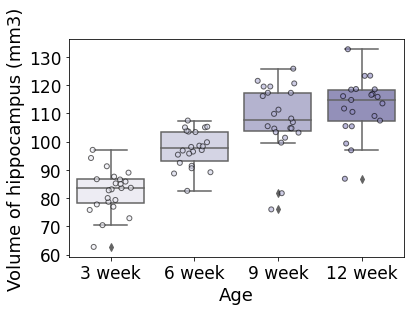

['12 week' '3 week' '6 week' '9 week']
[232]


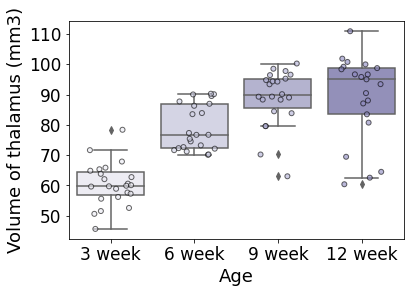

In [ ]:
plot_box(filename=r'sigma-hipp-label-BEN-brain.csv', cmap=sns.color_palette("Purples"))
plot_box(filename=r'sigma-tha-label-BEN-brain.csv', cmap=sns.color_palette("Purples"))

<a name="3.2"></a>
## 3.2 Using AFNI as preprocessing pipeline

In comparison, using AFNI as preprocessing pipeline produces poor atlas registration resulting in the propagation of error to 
the volumetric quantifications, and no obvious trend in the volumetric statistics was apparent (grey boxes).

['12 week' '3 week' '6 week' '9 week']
[742]


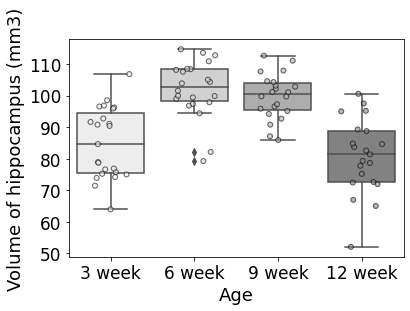

['12 week' '3 week' '6 week' '9 week']
[232]


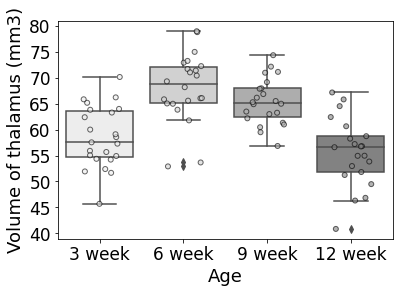

In [ ]:
plot_box(filename=r'sigma-hipp-afni-brain.csv', cmap=sns.color_palette("Greys"))
plot_box(filename=r'sigma-tha-afni-brain.csv', cmap=sns.color_palette("Greys"))

<a name="3.3"></a>
## 3.3 w/o brain extraction pre-processing as preprocessing pipeline 

In comparison, the atlas-based segmentations were poor when without BEN, and no 
obvious trend in the volumetric statistics was apparent (green boxes).

['12 week' '3 week' '6 week' '9 week']
[742]


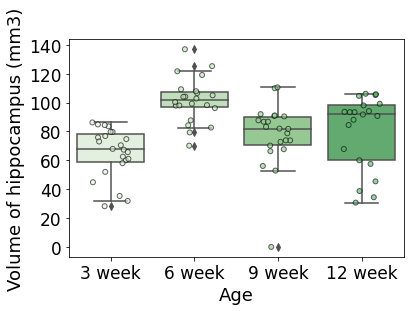

['12 week' '3 week' '6 week' '9 week']
[232]


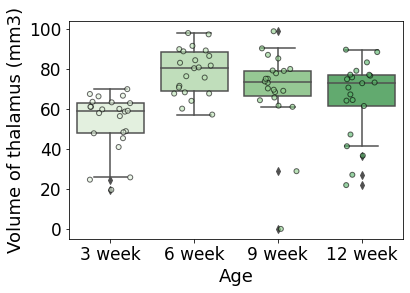

In [ ]:
plot_box(filename=r'sigma-hipp-WO-BEN-brain.csv')
plot_box(filename=r'sigma-tha-WO-BEN-brain.csv')

<a name='4.0' ></a>
# 4.0 Conclusion

Using BEN as a pre-registration toolbox enables observation of developmental patterns of brain structural volume not revealed by other tools. 


These results indicate that 
BEN not only is able to tremendously improve the registration accuracy and contribute to routine 
brain MRI processing but also is critical for longitudinal MRI studies, as it improves volumetric 
quantification.